In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# We started off by loading in policy and cases which were in a .parquet format
policy = pd.read_parquet('final_policy.parquet')
cases = pd.read_parquet('cases.parquet')

# Converted cases and policy from parquet to csv
cases.to_csv('final_policy.csv', index=False)
policy.to_csv('cases.csv', index=False)

# Read them as CSV
cases_df = pd.read_csv('final_policy.csv')
policy_df = pd.read_csv('cases.csv')

# Fixed errors in date format (python didn't like Azure's FullDate)

dtype = {
    'Column_2': str,
    'Column_3': str, 
    'Column_4': str, 
    'Column_7': str  
}

# Selected specific columns from policy that we needed for analysis (variable) 
policy_selected_columns = ['UniqueID','C1_School_closing', 'C1_Flag',
       'C2_Workplace_closing', 'C2_Flag', 'C3_Cancel_public_events', 'C3_Flag',
       'C4_Restrictions_on_gatherings', 'C4_Flag', 'C5_Close_public_transport',
       'C5_Flag', 'C6_Stay_at_home_requirements', 'C6_Flag',
       'C7_Restrictions_on_internal_movement', 'C7_Flag',
       'C8_International_travel_controls', 'E1_Income_support', 'E1_Flag',
       'E2_Debt_contract_relief', 'E3_Fiscal_measures',
       'E4_International_support', 'H1_Public_information_campaigns',
       'H1_Flag', 'H2_Testing_policy', 'H3_Contact_tracing',
       'H4_Emergency_investment_in_healthcare', 'H5_Investment_in_vaccines',
       'H6_Facial_Coverings', 'H6_Flag', 'H7_Vaccination_policy', 'H7_Flag',
       'H8_Protection_of_elderly_people', 'H8_Flag', 'M1_Wildcard','CountryCode']

# Removed unecessary rows from policy, which had the policy data from all of the countries
unique_country_codes = cases_df['CountryCode'].unique()
policy_selected = policy_df[policy_df['CountryCode'].isin(unique_country_codes)][policy_selected_columns]
policy_selected = policy_selected.drop_duplicates(subset='UniqueID')

# selected cases columns
cases_selected_columns = ['Confirmed_Change', 'CountryCode', 'UniqueID']
cases_selected = cases_df[cases_selected_columns]

In [162]:
#Downloaded external population data from United Nations World Population Prospects
pop_df = pd.read_csv('pop.csv', dtype=dtype, low_memory=False)

pop_df_2021 = pop_df[pop_df['Time'] == 2021]
pop_columns = ["ISO3_code", "PopTotal"]
pop_df_2021 = pop_df_2021[pop_df_2021['ISO3_code'].isin(unique_country_codes)][pop_columns]

# Converted data from population in thousands to raw population numbers
pop_df_2021['PopTotal'] = pop_df_2021['PopTotal'] * 1000

In [163]:
#Connected external population data by dividing confirmed cases by ...
#population of respective countries to get proportional data
merged_df = cases_selected.merge(policy_selected, on='UniqueID').dropna()

merged_pop_df = pd.merge(merged_df, pop_df_2021, left_on='CountryCode_y', right_on='ISO3_code', how='inner')

merged_pop_df['Confirmed_Per_Capita'] = merged_pop_df['Confirmed_Change'] / merged_pop_df['PopTotal'] * 100

In [176]:
# Created ML_DF, isolating variable and target/label columns only
final_cols = ['C1_School_closing',
       'C2_Workplace_closing', 'C3_Cancel_public_events',
       'C4_Restrictions_on_gatherings', 'C5_Close_public_transport','C6_Stay_at_home_requirements', 
       'C7_Restrictions_on_internal_movement', 
       'C8_International_travel_controls', 'E1_Income_support',
       'E2_Debt_contract_relief', 'E3_Fiscal_measures',
       'E4_International_support', 'H1_Public_information_campaigns','H2_Testing_policy', 'H3_Contact_tracing',
       'H4_Emergency_investment_in_healthcare', 'H5_Investment_in_vaccines',
       'H6_Facial_Coverings','H7_Vaccination_policy',
       'H8_Protection_of_elderly_people', 'Confirmed_Per_Capita']
ML_DF = merged_pop_df[final_cols]

In [222]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Isolated variable columns, target/label columns, train_test_split with 80% for test
variableColumns = ['C1_School_closing',
       'C2_Workplace_closing', 'C3_Cancel_public_events',
       'C4_Restrictions_on_gatherings', 'C5_Close_public_transport','C6_Stay_at_home_requirements', 
       'C7_Restrictions_on_internal_movement', 
       'C8_International_travel_controls', 'E1_Income_support',
       'E2_Debt_contract_relief', 'E3_Fiscal_measures',
       'E4_International_support', 'H1_Public_information_campaigns','H2_Testing_policy', 'H3_Contact_tracing',
       'H4_Emergency_investment_in_healthcare', 'H5_Investment_in_vaccines',
       'H6_Facial_Coverings','H7_Vaccination_policy',
       'H8_Protection_of_elderly_people']

data_train, data_test, label_train, label_test = train_test_split(ML_DF[variableColumns], ML_DF['Confirmed_Per_Capita'], test_size=0.80, random_state=45)

# Ran forestRegressor on the data, fitting training data and testing on the testing data 
forestRegressor = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=45)
forestRegressor.fit(data_train, label_train)
score = forestRegressor.score(data_test, label_test)
score

0.6819368827804371

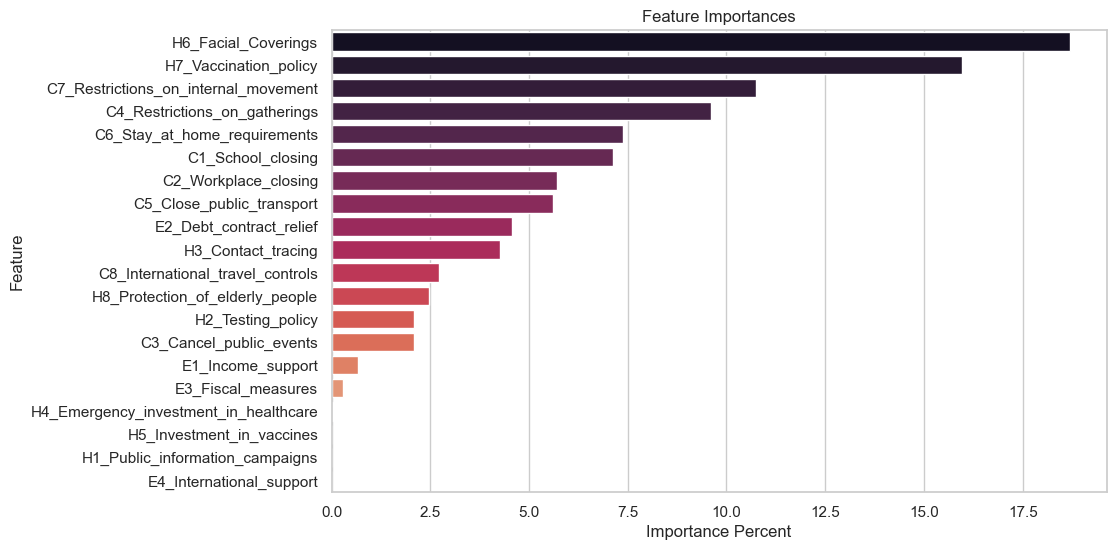

In [223]:
# Calculated feature importances using Random Forest Regressor, plotting them with a color coded bar chart 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

importances = forestRegressor.feature_importances_
feature_importance = pd.DataFrame({'Feature': trainingColumns, 'Importance Percent': importances})
feature_importance = feature_importance.sort_values(by='Importance Percent', ascending=False)
feature_importance['Importance Percent'] *= 100

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance Percent', y='Feature', data=feature_importance, palette='rocket')
plt.title('Feature Importances')
plt.xlabel('Importance Percent')
plt.ylabel('Feature')
plt.savefig('feature_importances.jpg')  
plt.show()